In [3]:
import os
import sys
sys.path.append('/home/cyberspace007/mpicek/NeuralMAE')
import numpy as np
import h5py
import torch
import torch.nn as nn
import scipy.io
from scipy.io import savemat
from omegaconf import OmegaConf

import neuralmae.util.misc as misc
import neuralmae.neural_models.models_multimodal_neuralmae_up2 as models_mae_multimodal
import neuralmae.neural_models.models_neuralmae_bsi as models_mae
import neuralmae.dataset.neural_dataset as dataset_n


### Loading only one session on which we'll test

In [4]:
cfg = OmegaConf.load('/home/cyberspace007/mpicek/NeuralMAE/neuralmae/dataset/config/UP2_multimodal_dataset_clinatec_test.yaml')
#cfg.dataset.transforms.tf.device = args.device # FIXME
#tranform_train = build_transform(is_train=True, cfg=cfg)
dataset_train = dataset_n.Up2MultimodalDatasetClinatec(cfg)

num_tasks = misc.get_world_size()
global_rank = misc.get_rank()
sampler_train = torch.utils.data.DistributedSampler(
    dataset_train, num_replicas=num_tasks, rank=global_rank, shuffle=False #FIXME
)
print("Sampler_train = %s" % str(sampler_train))

Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x7fc4e1a912b0>


In [5]:
# iterate over dataset

for i, data in enumerate(dataset_train):
    if data['video_index'] % 30 != 0:
        continue
    print(data.keys())
    if i > 10:
        break

dict_keys(['data', 'fs', 'targets', 'session', 'mean', 'std', 'video_index', 'video_path', '_video_start', '_video_end'])
dict_keys(['data', 'fs', 'targets', 'session', 'mean', 'std', 'video_index', 'video_path', '_video_start', '_video_end'])
dict_keys(['data', 'fs', 'targets', 'session', 'mean', 'std', 'video_index', 'video_path', '_video_start', '_video_end'])
dict_keys(['data', 'fs', 'targets', 'session', 'mean', 'std', 'video_index', 'video_path', '_video_start', '_video_end'])
dict_keys(['data', 'fs', 'targets', 'session', 'mean', 'std', 'video_index', 'video_path', '_video_start', '_video_end'])
dict_keys(['data', 'fs', 'targets', 'session', 'mean', 'std', 'video_index', 'video_path', '_video_start', '_video_end'])


### Load model

In [6]:

def prepare_pretrained_brainGPT(chkpt_dir, arch='mae_neut_base_patch245_1implant'):
    #build model
    model = getattr(models_mae, arch)()

    #load model
    chkpt = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(chkpt['model'], strict=False)
    print(msg)
    return model

def prepare_pretrained_brainGPT_multimodal(chkpt_dir):

    freeze_brainGPT = False
    model = models_mae_multimodal.__dict__['mae_neut_conf_tiny_multimodal_mlp_delta_DINO'](norm_pix_loss=False,
                                                    norm_session_loss=True,
                                                    uniformity_loss=False,
                                                    lamb=0.01,
                                                    # input_size=tuple(args.input_size), 
                                                    # patch_size=tuple(args.patch_size),
                                                    use_projector=False,
                                                    projector_dim=64,
                                                    freeze_brainGPT=freeze_brainGPT)

    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    model.load_state_dict(checkpoint['model'])

    return model


In [7]:

multimodal = True

if multimodal:
    # Multimodal BrainGPT (DINO)
    chkpt_dir = "/media/cyberspace007/T7/tmp/training_logs/neuralmae/checkpoints/MLP_predict_DINO_NOT_frozen_BrainGPT_25mask_small_weight_full_retrain/checkpoint-29.pth"
    model_mae = prepare_pretrained_brainGPT_multimodal(chkpt_dir)
    print('Multimodal BrainGPT model loaded.')
else:
    # Vanilla BrainGPT
    chkpt_dir = '/home/cyberspace007/mpicek/NeuralMAE/pretrained_brainGPT/checkpoint-14_up2001.pth'
    model_mae = prepare_pretrained_brainGPT(chkpt_dir, 'mae_neut_base_patch245_1implant')
    print('Vanilla BrainGPT model loaded.')


Number of parameters of the BrainGPT: 110.970265 M
Number of parameters of the DINO MLP Projector: 6.039552 M
Multimodal BrainGPT model loaded.


In [8]:
len(dataset_train)

1800

### Predict DINO with the model + concatenate right hand and head kinematics from the dataset

In [9]:
# extract latents
from tqdm import tqdm
device = torch.device('cuda:0')
model_mae = model_mae.to(device)
model_mae.freeze_brainGPT = True

with torch.no_grad():
    
    model_mae.eval()
    inputs, latents, targets, sessions = [], [], [], []
    dino_pred_last = []
    dino_pred_delta = []
    dino_target_last = []
    dino_target_delta = []

    right_hand = []
    head = []

    # for i in tqdm(range(all_data.shape[0])):
    for i, data in tqdm(enumerate(dataset_train)):
        # if data['video_index'] % 30 != 0:
        #     continue


        samp = data['data'].to(device, non_blocking=True, dtype=torch.float32).unsqueeze(0)

        with torch.cuda.amp.autocast():
            loss_reconstruction, pred, multimodal_predictions, mask = model_mae.forward(samp, data['targets']['dino_features'], mask_ratio=0.00, stats=None)
            dino_pred_last.append(multimodal_predictions['dino_features'].cpu().numpy()[0][:2048])
            dino_pred_delta.append(multimodal_predictions['dino_features'].cpu().numpy()[0][2048:])
            dino_target_last.append(data['targets']['dino_features'][:,-1])
            dino_target_delta.append(data['targets']['dino_features'][:,-1] - data['targets']['dino_features'][:,0])
            right_hand.append(data['targets']['kinematics'][:,4,:2])
            head.append(data['targets']['kinematics'][:,0,:2])

    right_hand = np.concatenate(right_hand, axis=0)
    head = np.concatenate(head, axis=0)
    dino_pred_last = np.stack(dino_pred_last, axis=0)
    dino_pred_delta = np.stack(dino_pred_delta, axis=0)
    dino_target_last = np.stack(dino_target_last, axis=0)
    dino_target_delta = np.stack(dino_target_delta, axis=0)

1800it [00:32, 55.13it/s]


### How well can we predict DINO with the BrainGPT? (evaluated by correlation)

In [10]:
from scipy.stats import pearsonr
correlation = np.zeros((2048,))
for i in range(2048):
    correlation[i] = pearsonr(dino_pred_last[:, i], dino_target_last[:, i])[0]
print(np.nanmean(correlation)) # 0.19676574366168387

/tmp/ipykernel_13145/3103538632.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation[i] = pearsonr(dino_pred_last[:, i], dino_target_last[:, i])[0]


0.2194822430990614


In [35]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')

def bar_plot(explained_variance_ratio, title, y_axis, save_path=None):
    """
    Plots the explained variance of components as a bar graph.

    Parameters:
    explained_variance_ratio (array-like): Array of explained variance ratios for each component.
    title (str): Title of the plot.
    y_axis (str): Label for the y-axis.
    save_path (str, optional): If provided, saves the plot to the specified path (both PNG and SVG).
    """
    n_components = len(explained_variance_ratio)
    ind = np.arange(n_components)

    plt.figure(figsize=(12, 4))
    bars = plt.bar(ind, explained_variance_ratio, align='center', alpha=0.7, color='#f9525b')
    
    # Setting labels and title
    plt.xlabel('Component', fontsize=14)
    plt.ylabel(y_axis, fontsize=14)
    plt.title(title, fontsize=18)
    plt.xticks(ind, ['PC{}'.format(i+1) for i in range(n_components)], fontsize=12)
    plt.ylim(0, 1)
    
    # Adding numbers on top of the columns
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

    # Remove the grid, y-axis ticks, and spines except for the x-axis
    plt.gca().spines['top'].set_color('none')
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['left'].set_color('none')
    plt.gca().yaxis.set_ticks([])
    plt.gca().spines['bottom'].set_color('black')
    
    # Only keep the x-axis
    plt.gca().spines['bottom'].set_linewidth(1)
    
    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(f"{save_path}.png", format='png', bbox_inches='tight')
        plt.savefig(f"{save_path}.svg", format='svg', bbox_inches='tight')
    
    plt.show()


### What PCs of DINO can be predicted (meaning they are captured by the brain)?

(1800, 10)
[ 0.90947952  0.23553018  0.05442877  0.19755688 -0.05549366  0.04307277
  0.05545496  0.11069106  0.04616408  0.00191328]
0.17097851547473256


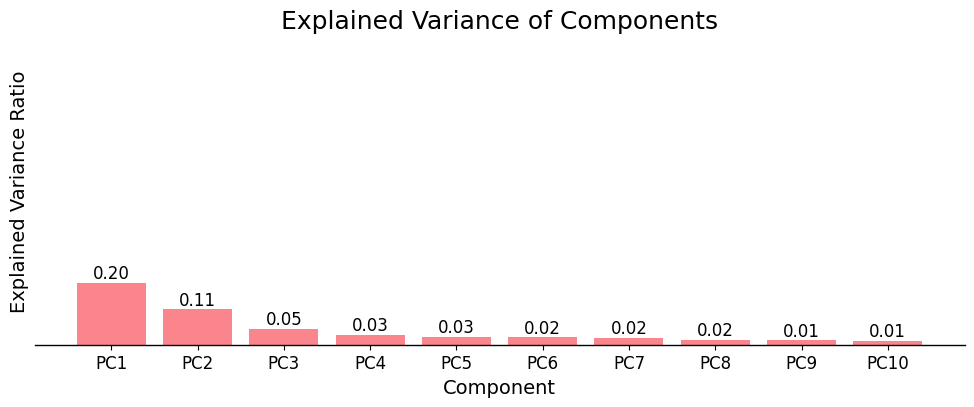

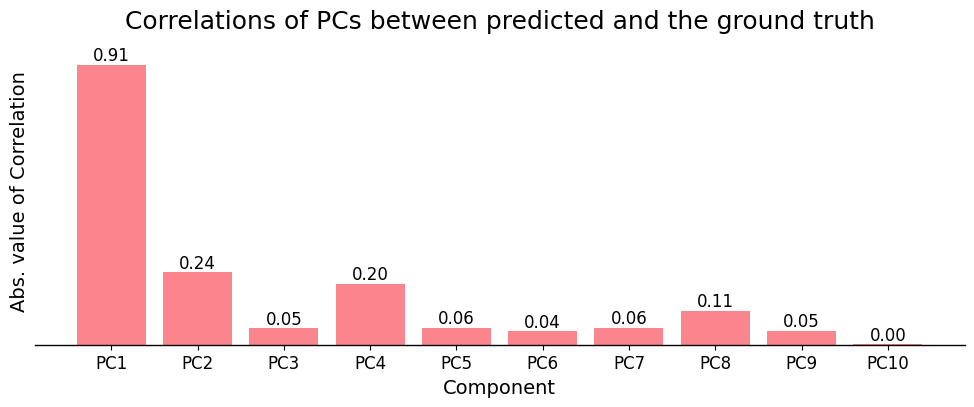

In [52]:
from sklearn.decomposition import PCA

y_true = dino_target_last
y_pred = dino_pred_last

components = 10

# Train PCA on the true values
pca = PCA(n_components=components)
pca.fit(y_true)

y_true_pca = pca.transform(y_true)
y_pred_pca = pca.transform(y_pred)
print(y_true_pca.shape)

correlation = np.zeros((components,))
for i in range(components):
    correlation[i] = pearsonr(y_true_pca[:, i], y_pred_pca[:, i])[0]
print(correlation)
print(np.nanmean(np.abs(correlation)))

bar_plot(pca.explained_variance_ratio_, title='Explained Variance of Components', y_axis='Explained Variance Ratio', save_path='results/explained_variance_DINO')
bar_plot(np.abs(correlation), title='Correlations of PCs between predicted and the ground truth', y_axis='Abs. value of Correlation', save_path='results/corr_PCs_ground_truth_and_prediction')

#### Preparing kinematics - removing the mean + removing the NaNs

In [53]:
# compute average of right_hand on sliding window of 30 frames (jumping by 30 frames)
right_hand_avg = []
for i in range(0, right_hand.shape[0], 30):
    right_hand_avg.append(np.mean(right_hand[i:i+30], axis=0))
right_hand_avg = np.array(right_hand_avg)
print(right_hand_avg.shape)

# compute average of right_hand on sliding window of 30 frames (jumping by 30 frames)
head_avg = []
for i in range(0, head.shape[0], 30):
    head_avg.append(np.mean(head[i:i+30], axis=0))
head_avg = np.array(head_avg)
print(head_avg.shape)

(1800, 2)
(1800, 2)


In [54]:
right_hand_avg

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32)

### What PCs correlate with the movement? (corr between ground truth movement and PCs)

In [55]:
# replace nans of right_hand_avg with zeros

right_hand_avg -= np.nanmean(right_hand_avg, axis=0)
right_hand_avg[np.isnan(right_hand_avg)] = 0

right_hand_correlations = np.zeros((components))

for i in range(2):
    for j in range(components):
        # correlate right_hand_avg with y_true_pca
        corr = pearsonr(right_hand_avg[:, i], y_true_pca[:, j])[0]
        right_hand_correlations[j] += np.abs(corr)
        print(f'Component {j} and right_hand_avg_{i}: {corr}')

print('--------------------')

head_avg -= np.nanmean(head_avg, axis=0)
head_avg[np.isnan(head_avg)] = 0

head_correlations = np.zeros((components))

for i in range(2):
    for j in range(components):
        # correlate right_hand_avg with y_true_pca
        corr = pearsonr(head_avg[:, i], y_true_pca[:, j])[0]
        head_correlations[j] += np.abs(corr)
        print(f'Component {j} and head_avg_{i}: {corr}')

Component 0 and right_hand_avg_0: -0.01664946085077323
Component 1 and right_hand_avg_0: -0.08665110017721599
Component 2 and right_hand_avg_0: -0.29889435915920803
Component 3 and right_hand_avg_0: 0.2769529218712969
Component 4 and right_hand_avg_0: 0.018345952815536457
Component 5 and right_hand_avg_0: -0.0967581599011766
Component 6 and right_hand_avg_0: 0.1580166969277493
Component 7 and right_hand_avg_0: 0.09848570321282354
Component 8 and right_hand_avg_0: 0.13086182110440367
Component 9 and right_hand_avg_0: 0.046138582053454544
Component 0 and right_hand_avg_1: -0.08725884558937537
Component 1 and right_hand_avg_1: -0.0059319978550687515
Component 2 and right_hand_avg_1: -0.16451201848346284
Component 3 and right_hand_avg_1: -0.24135695981091443
Component 4 and right_hand_avg_1: 0.282948220717022
Component 5 and right_hand_avg_1: -0.1276044251030312
Component 6 and right_hand_avg_1: -0.027570682421476353
Component 7 and right_hand_avg_1: 0.03564359093871649
Component 8 and rig

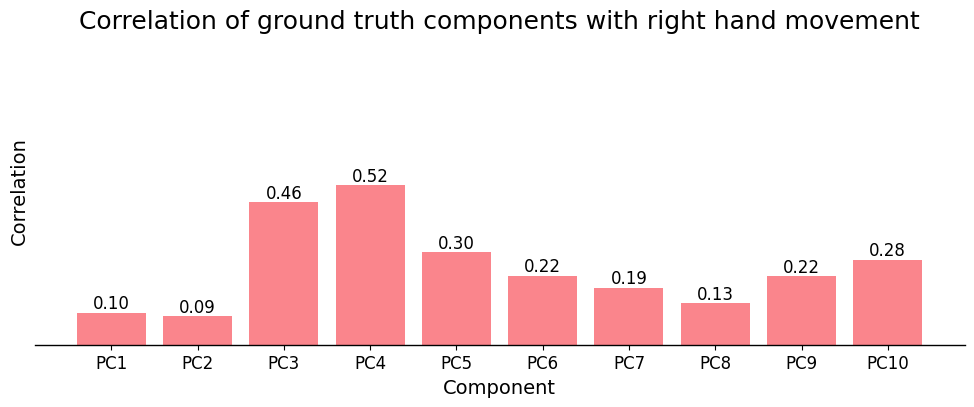

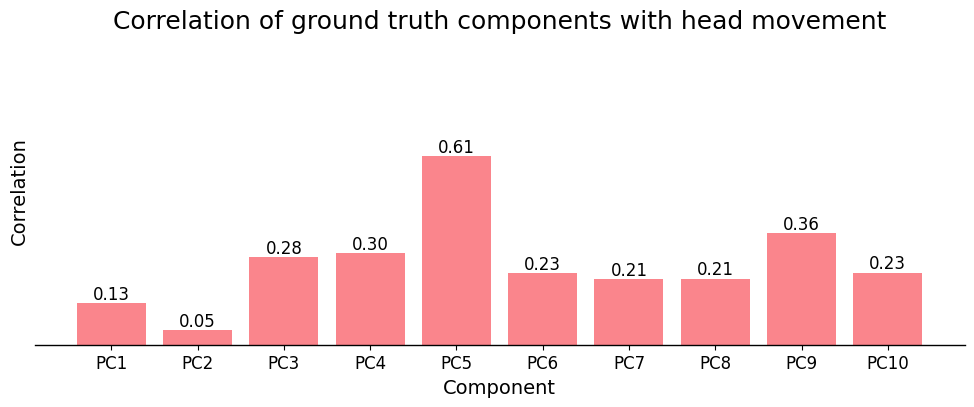

In [56]:
bar_plot(right_hand_correlations, title="Correlation of ground truth components with right hand movement", y_axis="Correlation", save_path='results/PCs_pred_head_corr')
bar_plot(head_correlations, title="Correlation of ground truth components with head movement", y_axis="Correlation", save_path='results/PCs_pred_head_corr')

### What PCs can be predicted from the brain?

In [57]:
# replace nans of right_hand_avg with zeros

right_hand_avg -= np.nanmean(right_hand_avg, axis=0)
right_hand_avg[np.isnan(right_hand_avg)] = 0

right_hand_correlations = np.zeros((components))

for i in range(2):
    for j in range(components):
        # correlate right_hand_avg with y_true_pca
        corr = pearsonr(right_hand_avg[:, i], y_pred_pca[:, j])[0]
        right_hand_correlations[j] += np.abs(corr)
        print(f'Component {j} and right_hand_avg_{i}: {corr}')

print("--------------")
head_avg -= np.nanmean(head_avg, axis=0)
head_avg[np.isnan(head_avg)] = 0

head_correlations = np.zeros((components))

for i in range(2):
    for j in range(components):
        # correlate head_avg with y_true_pca
        corr = pearsonr(head_avg[:, i], y_pred_pca[:, j])[0]
        head_correlations[j] += np.abs(corr)
        print(f'Component {j} and head_avg_{i}: {corr}')

Component 0 and right_hand_avg_0: -0.02252344061667737
Component 1 and right_hand_avg_0: -0.02548176079606267
Component 2 and right_hand_avg_0: -0.02760721450217788
Component 3 and right_hand_avg_0: -0.030838770474884928
Component 4 and right_hand_avg_0: -0.03682217614995246
Component 5 and right_hand_avg_0: 0.0038438601699865523
Component 6 and right_hand_avg_0: -0.00834877089296261
Component 7 and right_hand_avg_0: 0.0016975734915924234
Component 8 and right_hand_avg_0: 0.00700776464923333
Component 9 and right_hand_avg_0: 0.01338903960019731
Component 0 and right_hand_avg_1: -0.05750280019381381
Component 1 and right_hand_avg_1: 0.018667497678354773
Component 2 and right_hand_avg_1: 0.08314079811779665
Component 3 and right_hand_avg_1: -0.16953679353682619
Component 4 and right_hand_avg_1: 0.07242118419471778
Component 5 and right_hand_avg_1: -0.10906455791251138
Component 6 and right_hand_avg_1: -0.02286353531097522
Component 7 and right_hand_avg_1: 0.13764624585355564
Component 8 

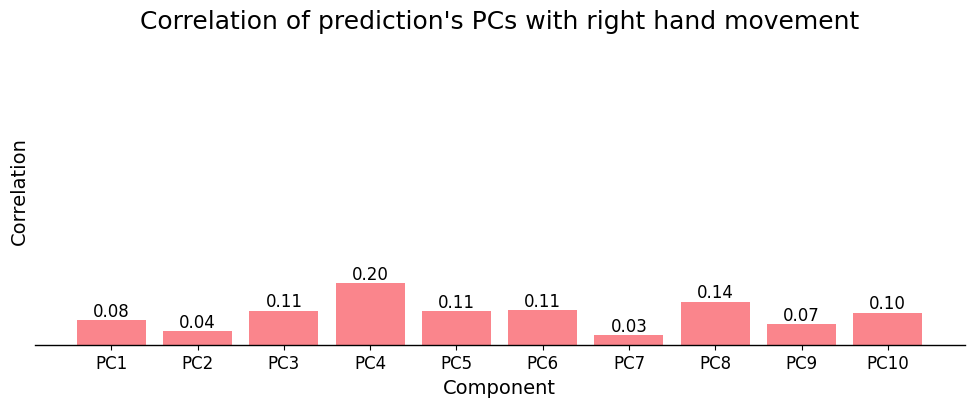

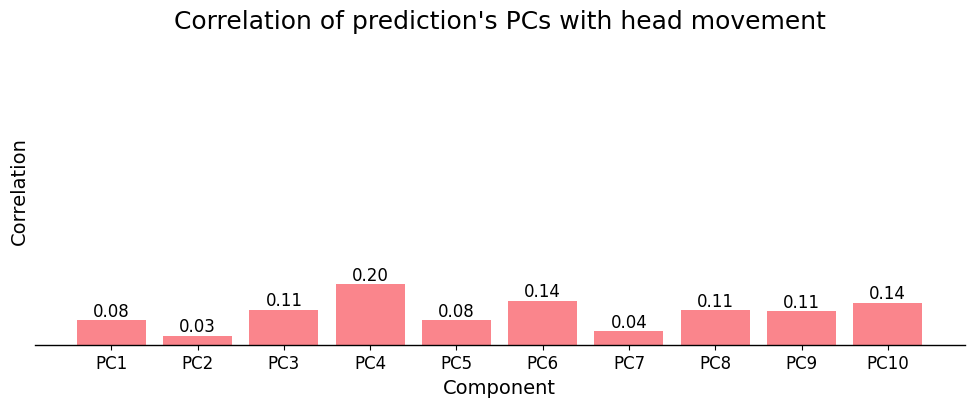

In [58]:
bar_plot(right_hand_correlations, title="Correlation of prediction's PCs with right hand movement", y_axis="Correlation", save_path='results/PCs_pred_right_hand_corr')
bar_plot(head_correlations, title="Correlation of prediction's PCs with head movement", y_axis="Correlation", save_path='results/PCs_pred_head_corr')

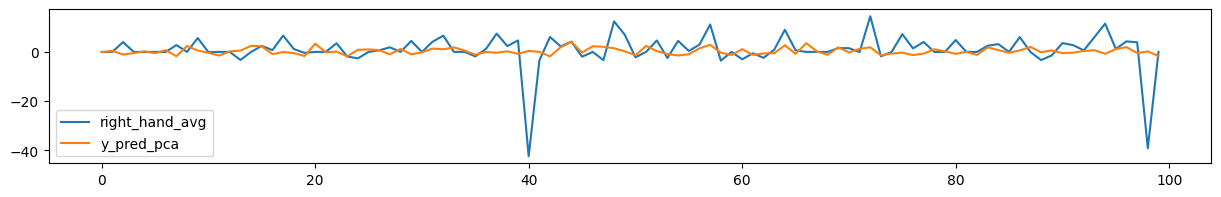

In [41]:
# RIGHT HAND AND PREDICTED ALIGNED
import matplotlib.pyplot as plt
# set a different color mode
plt.style.use('default')

plt.figure(figsize=(15, 2))
# start = 60000
# end = 60800
start = 1300
end = start + 100
# replace zeros with nans
plt.plot(right_hand_avg[start:end, 0], label='right_hand_avg')
plt.plot(y_pred_pca[start:end, 3], label='y_pred_pca')
plt.legend()
plt.show()



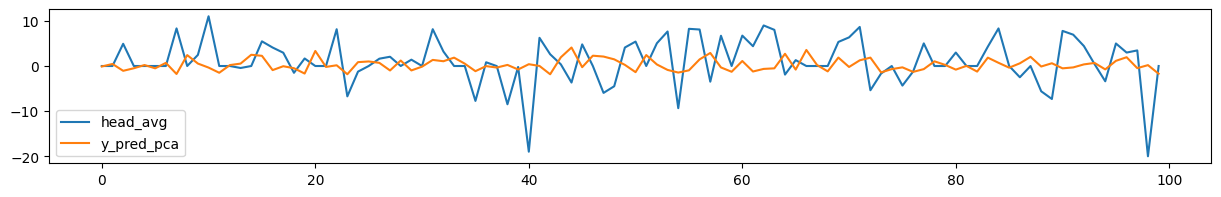

In [42]:
# HEAD AND PREDICTED ALIGNED
import matplotlib.pyplot as plt
# set a different color mode
plt.style.use('default')

plt.figure(figsize=(15, 2))
# start = 60000
# end = 60800
start = 1300
end = start + 100
# replace zeros with nans
plt.plot(head_avg[start:end, 0], label='head_avg')
plt.plot(y_pred_pca[start:end, 3], label='y_pred_pca')
plt.legend()
plt.show()



### What PCs correlate with the movement? (corr between ground truth mvmt and PCs)

Component 0 and right_hand_avg_0: -0.016649403552719703
Component 1 and right_hand_avg_0: -0.08665113185820268
Component 2 and right_hand_avg_0: -0.298894830639777
Component 3 and right_hand_avg_0: 0.27695186826408436
Component 4 and right_hand_avg_0: 0.01834426823815541
Component 5 and right_hand_avg_0: -0.09676843772660526
Component 6 and right_hand_avg_0: 0.1580431433183057
Component 7 and right_hand_avg_0: 0.09842424704006496
Component 8 and right_hand_avg_0: 0.1320416321404358
Component 9 and right_hand_avg_0: 0.04540151465636566
Component 0 and right_hand_avg_1: -0.08725883340000365
Component 1 and right_hand_avg_1: -0.0059320832696233925
Component 2 and right_hand_avg_1: -0.1645115419269517
Component 3 and right_hand_avg_1: -0.24135759664487352
Component 4 and right_hand_avg_1: 0.28294367783575475
Component 5 and right_hand_avg_1: -0.12761813064633423
Component 6 and right_hand_avg_1: -0.027514059612137685
Component 7 and right_hand_avg_1: 0.03533019726239829
Component 8 and rig

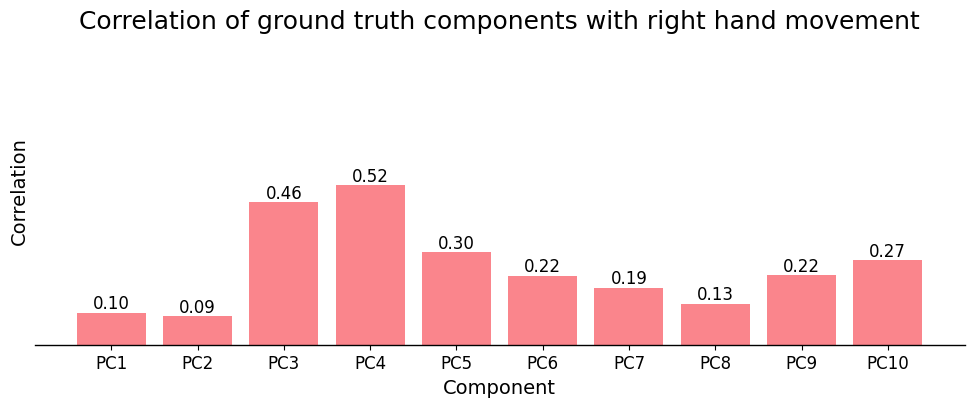

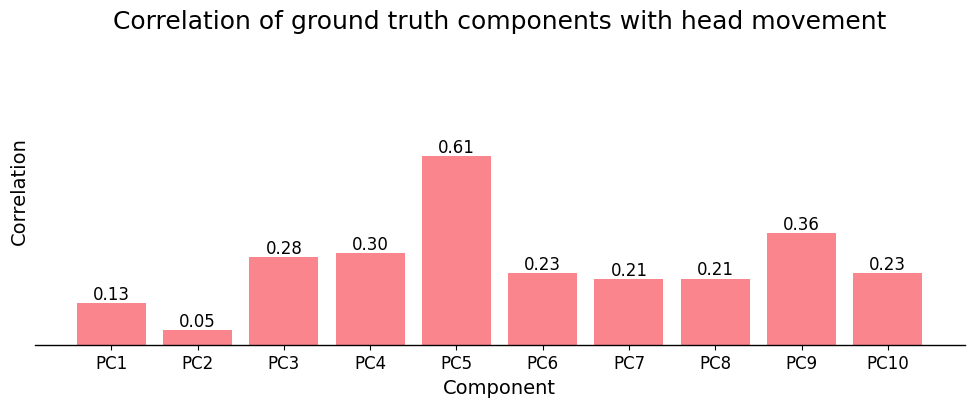